# Detección de patrones existentes en diferentes indicadores con respecto a datos de la COVID-19


<img src="covidLogo.png" alt="covid" style="float:left;" width="300"/>
<img src="./UOCLogo.jpg" alt="uoc" style="margin-top: 41px;float: right;" width="300"/>

__Universidad Oberta de Catalunya__


__Tipología y Ciclo de vida de los datos__


__Enrique Otero Espinosa__


__Francisco Javier Melchor González__

# Contexto

El contexto con el que está enfocado esta práctica, es tratar de realizar un análisis sobre la relación existente entre diferentes indicadores de los diferentes países del mundo (así como la expectancia de vida, la fertilidad, acceso a la electricidad...) y el número de muertes causadas por la pandemia COVID-19 en los mismos. 

Para conseguir el fin descrito anteriormente, se han elegido dos fuentes de datos:
- a) Por un lado, la **página https://www.worldometers.info/coronavirus/** que corresponde con la fuente de datos que proporciona información sobre la pandemia en los diferentes países, para obtener la información de la misma se ha utilizado la técnica de Web Scrapping 
- b) Por otro lado, la **librería wbdata**, que corresponde con la fuente de datos que proporciona información sobre los valores de los distintos indicadores de cada país. Dicha librería, realmente permite obtener información de la página del Banco Mundial de datos abiertos: https://databank.worldbank.org/home de una manera sencilla y parametrizada

La razón por la que se han elegido estas fuentes es porque se consideran fuentes de datos fiables y además de uso público que incluso normalmente se publican con el fin de que se puedan realizar estudios de investigación sobre los mismos, por lo que resulta más sencillo que obtenerlo de páginas que realmente no los publican con este fin.

# Título del dataset

Debido a que el dataset que se quiere conseguir fusiona información de la pandemia COVID-19 en los diferentes países y de los valores de los diferentes indicadores que se consideren a simple vista que pueden llegar a tener una relación con las muertes ocasionadas por la pandemia, el nombre que hemos elegido para el dataset que se va a generar es: **covid19AndWbIndicators**

# Representación gráfica
![RepGrafica](Covid_vs_WorldBankdata.jpeg)

# Código

In [1]:
import wbdata
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.ensemble import ExtraTreesClassifier
import statistics
from geopy.geocoders import Nominatim
import math
import folium
from folium.plugins import HeatMap
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import KMeans
import seaborn as sns


## Extracción de datos

In [2]:
url = 'https://www.worldometers.info/coronavirus/'
requests.get(url)
wdweb = requests.get(url)

In [3]:
wdweb

<Response [200]>

In [4]:
wdwebsoup = BeautifulSoup(wdweb.text, 'lxml')

In [5]:
wdwebtable_data = wdwebsoup.find('table', id = 'main_table_countries_yesterday')

In [6]:
headers = []
for i in wdwebtable_data.find_all('th'):
    title = i.text
    headers.append(title)

In [7]:
covid = pd.DataFrame(columns = headers)

In [8]:
for j in wdwebtable_data.find_all('tr')[1:]:
        row_data = j.find_all('td')
        row = [td.text for td in row_data]
        length = len(covid)
        covid.loc[length] = row

In [9]:
covid.columns = ['ID','country','TotalCases','NewCases','TotalDeaths','NewDeaths','TotalRecov','NewRecov','ActiveCases','SeriousCritical','TotalCases1M','TotalDeaths1M','TotalTests','TotalTests1M','Population','Continent','1CaseEvery','1DeathEvery','1TestEvery']
covid.set_index('country', inplace=True, drop=True)

In [10]:
covid.shape

(234, 18)

In [11]:
covid.index


Index(['\nAsia\n', '\nNorth America\n', '\nSouth America\n', '\nEurope\n',
       '\nAfrica\n', '\nOceania\n', '\n\n', 'World', 'China', 'USA',
       ...
       'Marshall Islands', 'Wallis and Futuna', 'Total:', 'Total:', 'Total:',
       'Total:', 'Total:', 'Total:', 'Total:', 'Total:'],
      dtype='object', name='country', length=234)

In [12]:
pd.set_option('display.max_rows', None)
covid.index=covid.index.str.replace("\n","")
covid=covid.rename(index={'USA': 'United States'})

In [13]:
data_date = datetime.datetime(2018, 12, 31), datetime.datetime(2018, 12, 31)
# countries = [i['id'] for i in wbdata.get_country(incomelevel='HIC')]
indicators = {"EG.ELC.ACCS.ZS":"AccessElectricity", "NY.GDP.MKTP.CD":"GDP", 
             "NY.GDP.PCAP.CD":"GDPperCap", "SH.XPD.CHEX.PC.CD":"HealthExpenseperCap", 
              "IT.NET.USER.ZS":"IndividUsingInternet", "SP.DYN.LE00.IN":"LifeExpect", 
              "SH.MED.PHYS.ZS":"DrsPer1k", "GB.XPD.RSDV.GD.ZS":"RDExpen", 
              "SH.HIV.INCD":"NewInfecHIV", "SP.DYN.TFRT.IN":"FertilityRate",
             "per_si_allsi.cov_pop_tot":"CovSocialInsurance", 
             "SP.URB.TOTL":"UrbanPopulation", "SP.URB.TOTL.IN.ZS":"UrbanPopulationPerc"}
wbdf = wbdata.get_dataframe(indicators, country="all", data_date=data_date)

In [14]:
covidandwb_merged = pd.merge(covid,wbdf, on=["country"])

In [15]:
covidandwb_merged.head()

,ID,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecov,NewRecov,ActiveCases,SeriousCritical,TotalCases1M,...,HealthExpenseperCap,IndividUsingInternet,LifeExpect,DrsPer1k,RDExpen,NewInfecHIV,FertilityRate,CovSocialInsurance,UrbanPopulation,UrbanPopulationPerc
country,,,,,,,,,,,,,,,,,,,,,
North America,,"11,676,256","+120,709","357,960","+1,815","7,697,604","+67,890","3,620,692","21,731",,...,None,88.498903,78.886891,NaN,2.739569,NaN,1.706032,NaN,2.989531e+08,82.173045
World,,"48,419,186","+574,691","1,230,109","+9,057","34,667,040","+320,758","12,522,037","89,292","6,212",...,None,NaN,72.563274,NaN,2.273640,1400000.0,2.414975,NaN,4.195080e+09,55.270426
China,1,"86,087",+17,"4,634",,"81,061",+16,392,9,60,...,None,NaN,76.704000,NaN,2.185680,NaN,1.690000,NaN,8.238276e+08,59.152000
United States,2,"9,801,355","+108,389","239,829","+1,201","6,292,019","+55,849","3,269,507","18,045","29,551",...,None,88.498903,78.539024,NaN,2.837660,33000.0,1.729500,NaN,2.687201e+08,82.256000
India,3,"8,363,412","+50,465","124,354",+704,"7,710,630","+55,873","528,428","8,944","6,040",...,None,20.081300,69.416000,0.8571,0.649980,NaN,2.222000,NaN,4.602957e+08,34.030000


In [16]:
covidandwb_merged.shape

(172, 31)

In [17]:
covidandwb = covidandwb_merged

## Procesamiento de los datos obtenidos

In [18]:
covidandwb = covidandwb.drop(["NewCases", "NewDeaths", "TotalRecov", "NewRecov", 
                              "ActiveCases", "SeriousCritical"], axis=1)
covidandwb = covidandwb.drop(["World"], axis=0)
covidandwb = covidandwb.drop(["North America"], axis=0)

In [19]:
covidandwb.head()

,ID,TotalCases,TotalDeaths,TotalCases1M,TotalDeaths1M,TotalTests,TotalTests1M,Population,Continent,1CaseEvery,...,HealthExpenseperCap,IndividUsingInternet,LifeExpect,DrsPer1k,RDExpen,NewInfecHIV,FertilityRate,CovSocialInsurance,UrbanPopulation,UrbanPopulationPerc
country,,,,,,,,,,,,,,,,,,,,,
China,1,"86,087","4,634",60,3,"160,000,000","111,163","1,439,323,776",Asia,"16,719",...,None,NaN,76.704000,NaN,2.18568,NaN,1.6900,NaN,823827650.0,59.152
United States,2,"9,801,355","239,829","29,551",723,"152,050,414","458,433","331,674,530",North America,34,...,None,88.498903,78.539024,NaN,2.83766,33000.0,1.7295,NaN,268720071.0,82.256
India,3,"8,363,412","124,354","6,040",90,"112,998,959","81,607","1,384,678,624",Asia,166,...,None,20.081300,69.416000,0.8571,0.64998,NaN,2.2220,NaN,460295677.0,34.030
Brazil,4,"5,590,941","161,170","26,238",756,"21,900,000","102,777","213,081,672",South America,38,...,None,70.434283,75.672000,2.1643,NaN,NaN,1.7300,30.869548,181335507.0,86.569
France,6,"1,543,321","38,674","23,626",592,"16,819,377","257,477","65,323,720",Europe,42,...,None,82.043187,82.724390,3.2672,2.20002,NaN,1.8800,NaN,53870058.0,80.444


In [20]:
TotalDeathsindex = covidandwb[covidandwb['TotalDeaths'].str.match(' ')].index
covidandwb.loc[TotalDeathsindex, 'TotalDeaths'] = 0
covidandwb['TotalDeaths']=covidandwb['TotalDeaths'].str.replace(",","").astype(float)
covidandwb.loc[TotalDeathsindex, 'TotalDeaths1M'] = 0
covidandwb['TotalDeaths1M']=covidandwb['TotalDeaths1M'].str.replace(",","").astype(float)
covidandwb['TotalCases1M']=covidandwb['TotalCases1M'].str.replace(",","").astype(float)
covidandwb['TotalCases']=covidandwb['TotalCases'].str.replace(",","").astype(float)

In [21]:
covidandwb.head()

,ID,TotalCases,TotalDeaths,TotalCases1M,TotalDeaths1M,TotalTests,TotalTests1M,Population,Continent,1CaseEvery,...,HealthExpenseperCap,IndividUsingInternet,LifeExpect,DrsPer1k,RDExpen,NewInfecHIV,FertilityRate,CovSocialInsurance,UrbanPopulation,UrbanPopulationPerc
country,,,,,,,,,,,,,,,,,,,,,
China,1,86087.0,4634.0,60.0,3.0,"160,000,000","111,163","1,439,323,776",Asia,"16,719",...,None,NaN,76.704000,NaN,2.18568,NaN,1.6900,NaN,823827650.0,59.152
United States,2,9801355.0,239829.0,29551.0,723.0,"152,050,414","458,433","331,674,530",North America,34,...,None,88.498903,78.539024,NaN,2.83766,33000.0,1.7295,NaN,268720071.0,82.256
India,3,8363412.0,124354.0,6040.0,90.0,"112,998,959","81,607","1,384,678,624",Asia,166,...,None,20.081300,69.416000,0.8571,0.64998,NaN,2.2220,NaN,460295677.0,34.030
Brazil,4,5590941.0,161170.0,26238.0,756.0,"21,900,000","102,777","213,081,672",South America,38,...,None,70.434283,75.672000,2.1643,NaN,NaN,1.7300,30.869548,181335507.0,86.569
France,6,1543321.0,38674.0,23626.0,592.0,"16,819,377","257,477","65,323,720",Europe,42,...,None,82.043187,82.724390,3.2672,2.20002,NaN,1.8800,NaN,53870058.0,80.444


In [22]:
covidandwb.dtypes

ID                       object
TotalCases              float64
TotalDeaths             float64
TotalCases1M            float64
TotalDeaths1M           float64
TotalTests               object
TotalTests1M             object
Population               object
Continent                object
1CaseEvery               object
1DeathEvery              object
1TestEvery               object
AccessElectricity       float64
GDP                     float64
GDPperCap               float64
HealthExpenseperCap      object
IndividUsingInternet    float64
LifeExpect              float64
DrsPer1k                float64
RDExpen                 float64
NewInfecHIV             float64
FertilityRate           float64
CovSocialInsurance      float64
UrbanPopulation         float64
UrbanPopulationPerc     float64
dtype: object

In [23]:
covidandwb['1DeathEvery']= covidandwb['1DeathEvery'].str.replace(",","")
covidandwb['1DeathEvery']=covidandwb['1DeathEvery'].str.replace(r'^\s*$','NaN')
covidandwb['1DeathEvery']=covidandwb['1DeathEvery'].astype(float)

In [24]:
covidandwb['TotalTests']= covidandwb['TotalTests'].str.replace(",","")
covidandwb['TotalTests']=covidandwb['TotalTests'].str.replace(r'^\s*$','NaN')
covidandwb['TotalTests']=covidandwb['TotalTests'].astype(float)

In [25]:
covidandwb['TotalTests1M']= covidandwb['TotalTests1M'].str.replace(",","")
covidandwb['TotalTests1M']=covidandwb['TotalTests1M'].str.replace(r'^\s*$','NaN')
covidandwb['TotalTests1M']=covidandwb['TotalTests1M'].astype(float)

In [26]:
covidandwb['Population']= covidandwb['Population'].str.replace(",","")
covidandwb['Population']=covidandwb['Population'].str.replace(r'^\s*$','NaN')
covidandwb['Population']=covidandwb['Population'].astype(float)

In [27]:
covidandwb['1CaseEvery']= covidandwb['1CaseEvery'].str.replace(",","")
covidandwb['1CaseEvery']=covidandwb['1CaseEvery'].str.replace(r'^\s*$','NaN')
covidandwb['1CaseEvery']=covidandwb['1CaseEvery'].astype(float)

In [28]:
covidandwb['HealthExpenseperCap']= covidandwb['HealthExpenseperCap'].str.replace(",","")
covidandwb['HealthExpenseperCap']=covidandwb['HealthExpenseperCap'].str.replace(r'^\s*$','NaN')
covidandwb['HealthExpenseperCap']=covidandwb['HealthExpenseperCap'].astype(float)

In [29]:
covidandwb['1TestEvery']= covidandwb['1TestEvery'].str.replace(",","")
covidandwb['1TestEvery']=covidandwb['1TestEvery'].str.replace(r'^\s*$','NaN')
covidandwb['1TestEvery']=covidandwb['1TestEvery'].astype(float)

In [30]:
covidandwb.dtypes

ID                       object
TotalCases              float64
TotalDeaths             float64
TotalCases1M            float64
TotalDeaths1M           float64
TotalTests              float64
TotalTests1M            float64
Population              float64
Continent                object
1CaseEvery              float64
1DeathEvery             float64
1TestEvery              float64
AccessElectricity       float64
GDP                     float64
GDPperCap               float64
HealthExpenseperCap     float64
IndividUsingInternet    float64
LifeExpect              float64
DrsPer1k                float64
RDExpen                 float64
NewInfecHIV             float64
FertilityRate           float64
CovSocialInsurance      float64
UrbanPopulation         float64
UrbanPopulationPerc     float64
dtype: object

In [31]:
covidandwb.shape

(170, 25)

In [32]:
covidandwb.isnull().sum()

ID                        0
TotalCases                0
TotalDeaths              13
TotalCases1M              0
TotalDeaths1M            13
TotalTests               13
TotalTests1M             13
Population                0
Continent                 0
1CaseEvery                0
1DeathEvery              13
1TestEvery               13
AccessElectricity         1
GDP                      12
GDPperCap                12
HealthExpenseperCap     170
IndividUsingInternet     97
LifeExpect               10
DrsPer1k                114
RDExpen                 110
NewInfecHIV              66
FertilityRate             9
CovSocialInsurance      164
UrbanPopulation           1
UrbanPopulationPerc       1
dtype: int64

In [33]:
covidandwb.columns

Index(['ID', 'TotalCases', 'TotalDeaths', 'TotalCases1M', 'TotalDeaths1M',
       'TotalTests', 'TotalTests1M', 'Population', 'Continent', '1CaseEvery',
       '1DeathEvery', '1TestEvery', 'AccessElectricity', 'GDP', 'GDPperCap',
       'HealthExpenseperCap', 'IndividUsingInternet', 'LifeExpect', 'DrsPer1k',
       'RDExpen', 'NewInfecHIV', 'FertilityRate', 'CovSocialInsurance',
       'UrbanPopulation', 'UrbanPopulationPerc'],
      dtype='object')

Eliminamos:
* **CovSocialInsurance**
* **RDExpen**
* **HealthExpenseperCap**
* **IndividUsingInternet**

Debido a que todas ellas cuentan con más de un 60% de datos nulos

In [34]:
columns_acceptables = ['ID', 'TotalCases', 'TotalDeaths', 'TotalCases1M', 'TotalDeaths1M',
       'TotalTests', 'TotalTests1M', 'Population', 'Continent', '1CaseEvery',
       '1DeathEvery', '1TestEvery', 'AccessElectricity', 'GDP', 'GDPperCap', 'LifeExpect','DrsPer1k', 'NewInfecHIV', 'FertilityRate',
       'UrbanPopulation', 'UrbanPopulationPerc']

In [35]:
covidandwb = covidandwb[columns_acceptables]
covidandwb.isnull().sum()

ID                       0
TotalCases               0
TotalDeaths             13
TotalCases1M             0
TotalDeaths1M           13
TotalTests              13
TotalTests1M            13
Population               0
Continent                0
1CaseEvery               0
1DeathEvery             13
1TestEvery              13
AccessElectricity        1
GDP                     12
GDPperCap               12
LifeExpect              10
DrsPer1k               114
NewInfecHIV             66
FertilityRate            9
UrbanPopulation          1
UrbanPopulationPerc      1
dtype: int64

In [36]:
def imputationFunct(x, indexColumn):
    if math.isnan(x.iloc[indexColumn]):
        x.iloc[indexColumn] = statistics.median(covidandwb.loc[covidandwb['Continent'] == x.iloc[8]].iloc[:, indexColumn].dropna())
    return x.iloc[indexColumn]

In [37]:
columnsWithNaN = [2,4,5,6,10,11,12,13,14,15,16,17,18,19,20]

### Imputation Data

In [38]:
for column in columnsWithNaN:
    covidandwb.iloc[:,[column]] = covidandwb.apply(imputationFunct,axis=1,args=(column,))

In [39]:
covidandwb.isnull().sum()

ID                     0
TotalCases             0
TotalDeaths            0
TotalCases1M           0
TotalDeaths1M          0
TotalTests             0
TotalTests1M           0
Population             0
Continent              0
1CaseEvery             0
1DeathEvery            0
1TestEvery             0
AccessElectricity      0
GDP                    0
GDPperCap              0
LifeExpect             0
DrsPer1k               0
NewInfecHIV            0
FertilityRate          0
UrbanPopulation        0
UrbanPopulationPerc    0
dtype: int64

In [40]:
covidandwb.head()

,ID,TotalCases,TotalDeaths,TotalCases1M,TotalDeaths1M,TotalTests,TotalTests1M,Population,Continent,1CaseEvery,...,1TestEvery,AccessElectricity,GDP,GDPperCap,LifeExpect,DrsPer1k,NewInfecHIV,FertilityRate,UrbanPopulation,UrbanPopulationPerc
country,,,,,,,,,,,,,,,,,,,,,
China,1,86087.0,4634.0,60.0,3.0,160000000.0,111163.0,1.439324e+09,Asia,16719.0,...,9.0,100.000000,1.389482e+13,9976.676822,76.704000,0.9186,1050.0,1.6900,823827650.0,59.152
United States,2,9801355.0,239829.0,29551.0,723.0,152050414.0,458433.0,3.316745e+08,North America,34.0,...,2.0,100.000000,2.052905e+13,62840.020239,78.539024,1.9357,33000.0,1.7295,268720071.0,82.256
India,3,8363412.0,124354.0,6040.0,90.0,112998959.0,81607.0,1.384679e+09,Asia,166.0,...,12.0,95.235855,2.713165e+12,2005.863005,69.416000,0.8571,1050.0,2.2220,460295677.0,34.030
Brazil,4,5590941.0,161170.0,26238.0,756.0,21900000.0,102777.0,2.130817e+08,South America,38.0,...,10.0,100.000000,1.885483e+12,9001.234249,75.672000,2.1643,2300.0,1.7300,181335507.0,86.569
France,6,1543321.0,38674.0,23626.0,592.0,16819377.0,257477.0,6.532372e+07,Europe,42.0,...,4.0,100.000000,2.787864e+12,41631.090739,82.724390,3.2672,500.0,1.8800,53870058.0,80.444


In [41]:
geolocator = Nominatim(user_agent='myapplication')

In [42]:
def getLatitude(x):
    return geolocator.geocode(x[0]).latitude

In [43]:
def getLongitude(x):
    return geolocator.geocode(x[0]).longitude

In [44]:
covidandwb.head()

,ID,TotalCases,TotalDeaths,TotalCases1M,TotalDeaths1M,TotalTests,TotalTests1M,Population,Continent,1CaseEvery,...,1TestEvery,AccessElectricity,GDP,GDPperCap,LifeExpect,DrsPer1k,NewInfecHIV,FertilityRate,UrbanPopulation,UrbanPopulationPerc
country,,,,,,,,,,,,,,,,,,,,,
China,1,86087.0,4634.0,60.0,3.0,160000000.0,111163.0,1.439324e+09,Asia,16719.0,...,9.0,100.000000,1.389482e+13,9976.676822,76.704000,0.9186,1050.0,1.6900,823827650.0,59.152
United States,2,9801355.0,239829.0,29551.0,723.0,152050414.0,458433.0,3.316745e+08,North America,34.0,...,2.0,100.000000,2.052905e+13,62840.020239,78.539024,1.9357,33000.0,1.7295,268720071.0,82.256
India,3,8363412.0,124354.0,6040.0,90.0,112998959.0,81607.0,1.384679e+09,Asia,166.0,...,12.0,95.235855,2.713165e+12,2005.863005,69.416000,0.8571,1050.0,2.2220,460295677.0,34.030
Brazil,4,5590941.0,161170.0,26238.0,756.0,21900000.0,102777.0,2.130817e+08,South America,38.0,...,10.0,100.000000,1.885483e+12,9001.234249,75.672000,2.1643,2300.0,1.7300,181335507.0,86.569
France,6,1543321.0,38674.0,23626.0,592.0,16819377.0,257477.0,6.532372e+07,Europe,42.0,...,4.0,100.000000,2.787864e+12,41631.090739,82.724390,3.2672,500.0,1.8800,53870058.0,80.444


In [45]:
covidandwb = covidandwb.reset_index()
covidandwb.head()

,country,ID,TotalCases,TotalDeaths,TotalCases1M,TotalDeaths1M,TotalTests,TotalTests1M,Population,Continent,...,1TestEvery,AccessElectricity,GDP,GDPperCap,LifeExpect,DrsPer1k,NewInfecHIV,FertilityRate,UrbanPopulation,UrbanPopulationPerc
0,China,1,86087.0,4634.0,60.0,3.0,160000000.0,111163.0,1.439324e+09,Asia,...,9.0,100.000000,1.389482e+13,9976.676822,76.704000,0.9186,1050.0,1.6900,823827650.0,59.152
1,United States,2,9801355.0,239829.0,29551.0,723.0,152050414.0,458433.0,3.316745e+08,North America,...,2.0,100.000000,2.052905e+13,62840.020239,78.539024,1.9357,33000.0,1.7295,268720071.0,82.256
2,India,3,8363412.0,124354.0,6040.0,90.0,112998959.0,81607.0,1.384679e+09,Asia,...,12.0,95.235855,2.713165e+12,2005.863005,69.416000,0.8571,1050.0,2.2220,460295677.0,34.030
3,Brazil,4,5590941.0,161170.0,26238.0,756.0,21900000.0,102777.0,2.130817e+08,South America,...,10.0,100.000000,1.885483e+12,9001.234249,75.672000,2.1643,2300.0,1.7300,181335507.0,86.569
4,France,6,1543321.0,38674.0,23626.0,592.0,16819377.0,257477.0,6.532372e+07,Europe,...,4.0,100.000000,2.787864e+12,41631.090739,82.724390,3.2672,500.0,1.8800,53870058.0,80.444


In [46]:
covidandwb['Latitude'] = covidandwb.apply(getLatitude,axis=1)

In [47]:
covidandwb['Longitude'] = covidandwb.apply(getLongitude,axis=1)

In [48]:
covidandwb.head()

,country,ID,TotalCases,TotalDeaths,TotalCases1M,TotalDeaths1M,TotalTests,TotalTests1M,Population,Continent,...,GDP,GDPperCap,LifeExpect,DrsPer1k,NewInfecHIV,FertilityRate,UrbanPopulation,UrbanPopulationPerc,Latitude,Longitude
0,China,1,86087.0,4634.0,60.0,3.0,160000000.0,111163.0,1.439324e+09,Asia,...,1.389482e+13,9976.676822,76.704000,0.9186,1050.0,1.6900,823827650.0,59.152,35.000074,104.999927
1,United States,2,9801355.0,239829.0,29551.0,723.0,152050414.0,458433.0,3.316745e+08,North America,...,2.052905e+13,62840.020239,78.539024,1.9357,33000.0,1.7295,268720071.0,82.256,39.783730,-100.445882
2,India,3,8363412.0,124354.0,6040.0,90.0,112998959.0,81607.0,1.384679e+09,Asia,...,2.713165e+12,2005.863005,69.416000,0.8571,1050.0,2.2220,460295677.0,34.030,22.351115,78.667743
3,Brazil,4,5590941.0,161170.0,26238.0,756.0,21900000.0,102777.0,2.130817e+08,South America,...,1.885483e+12,9001.234249,75.672000,2.1643,2300.0,1.7300,181335507.0,86.569,-10.333333,-53.200000
4,France,6,1543321.0,38674.0,23626.0,592.0,16819377.0,257477.0,6.532372e+07,Europe,...,2.787864e+12,41631.090739,82.724390,3.2672,500.0,1.8800,53870058.0,80.444,46.603354,1.888334


## Representaciones gráficas de los datos

### HeatMap

In [49]:
map_hooray = folium.Map([40.4166359,-3.7059988], zoom_start=3)


In [50]:
HeatMap(data=covidandwb[['Latitude','Longitude','TotalCases1M']].groupby(['Latitude','Longitude']).sum().reset_index().values.tolist()).add_to(map_hooray)


In [51]:
map_hooray

In [52]:
covidandwb.set_index('country', inplace=True, drop=True)


### Plots of relations

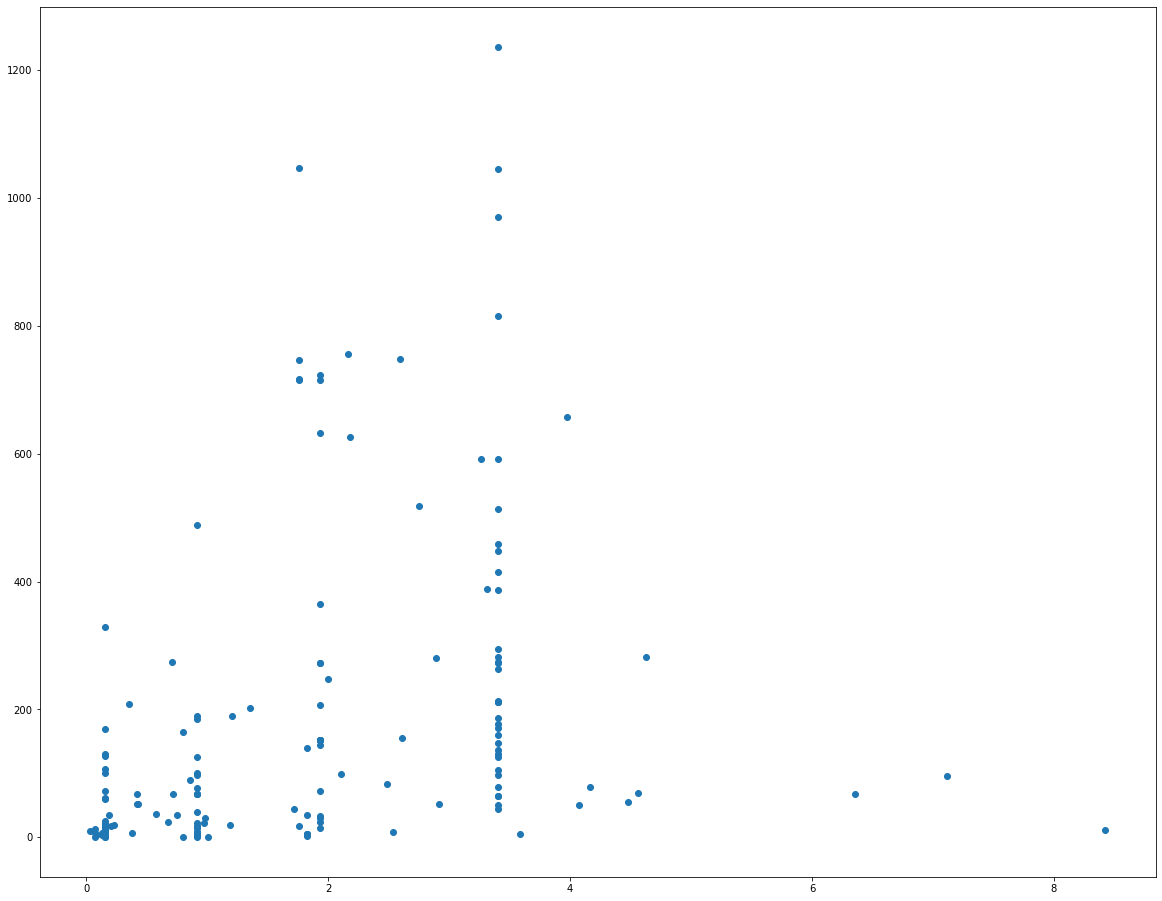

In [53]:
%matplotlib inline
rcParams['figure.figsize'] = 20,16
plt.scatter(covidandwb['DrsPer1k'], covidandwb['TotalDeaths1M'])
plt.show()

In [54]:
# Recreamos el campo UrbanPopulationPerc

In [55]:
covidandwb['UrbanPopulationPerc'].head()

country
China            59.152
United States    82.256
India            34.030
Brazil           86.569
France           80.444
Name: UrbanPopulationPerc, dtype: float64

In [56]:
def fx(x, y):
    return x*100/y
covidandwb['UrbanPopulationPerc'] = np.vectorize(fx)(covidandwb['UrbanPopulation'], covidandwb['Population'])

In [57]:
covidandwb['UrbanPopulationPerc'].head()

country
China            57.237132
United States    81.019206
India            33.242058
Brazil           85.101410
France           82.466305
Name: UrbanPopulationPerc, dtype: float64

In [58]:
# Exportamos el Datframe final a CSV

In [59]:
csv_path='./covidandwb.csv'
covidandwb.to_csv(csv_path, index=False, header=True)

### Clusterización con KMeans

In [60]:
covidkmeans_cols=['TotalDeaths1M', 'TotalTests1M', 'GDPperCap', 'LifeExpect','DrsPer1k', 'NewInfecHIV', 'FertilityRate',
       'UrbanPopulation']
covidkmeans=covidandwb[covidkmeans_cols]
covidkmeans.head()

,TotalDeaths1M,TotalTests1M,GDPperCap,LifeExpect,DrsPer1k,NewInfecHIV,FertilityRate,UrbanPopulation
country,,,,,,,,
China,3.0,111163.0,9976.676822,76.704000,0.9186,1050.0,1.6900,823827650.0
United States,723.0,458433.0,62840.020239,78.539024,1.9357,33000.0,1.7295,268720071.0
India,90.0,81607.0,2005.863005,69.416000,0.8571,1050.0,2.2220,460295677.0
Brazil,756.0,102777.0,9001.234249,75.672000,2.1643,2300.0,1.7300,181335507.0
France,592.0,257477.0,41631.090739,82.724390,3.2672,500.0,1.8800,53870058.0


In [61]:
scaler = preprocessing.MinMaxScaler()
features_normal = scaler.fit_transform(covidkmeans)

In [62]:
features_normal

array([[2.36070239e-03, 5.43155082e-02, 5.23015077e-02, ...,
        5.00263296e-03, 9.52710896e-02, 1.00000000e+00],
       [5.84451703e-01, 2.24249349e-01, 3.37191152e-01, ...,
        1.73249078e-01, 1.02113286e-01, 3.26180371e-01],
       [7.26966983e-02, 3.98525123e-02, 9.34542203e-03, ...,
        5.00263296e-03, 1.87424216e-01, 5.58725212e-01],
       ...,
       [1.22821201e-01, 9.46446397e-02, 2.92088828e-01, ...,
        5.00263296e-03, 1.48969340e-01, 5.24397124e-05],
       [3.97762183e-03, 0.00000000e+00, 1.00558641e-02, ...,
        2.63296472e-03, 5.65217391e-01, 1.81605931e-04],
       [3.97762183e-03, 2.68252461e-02, 1.89505462e-02, ...,
        2.63296472e-03, 1.43772735e-01, 4.80200695e-05]])

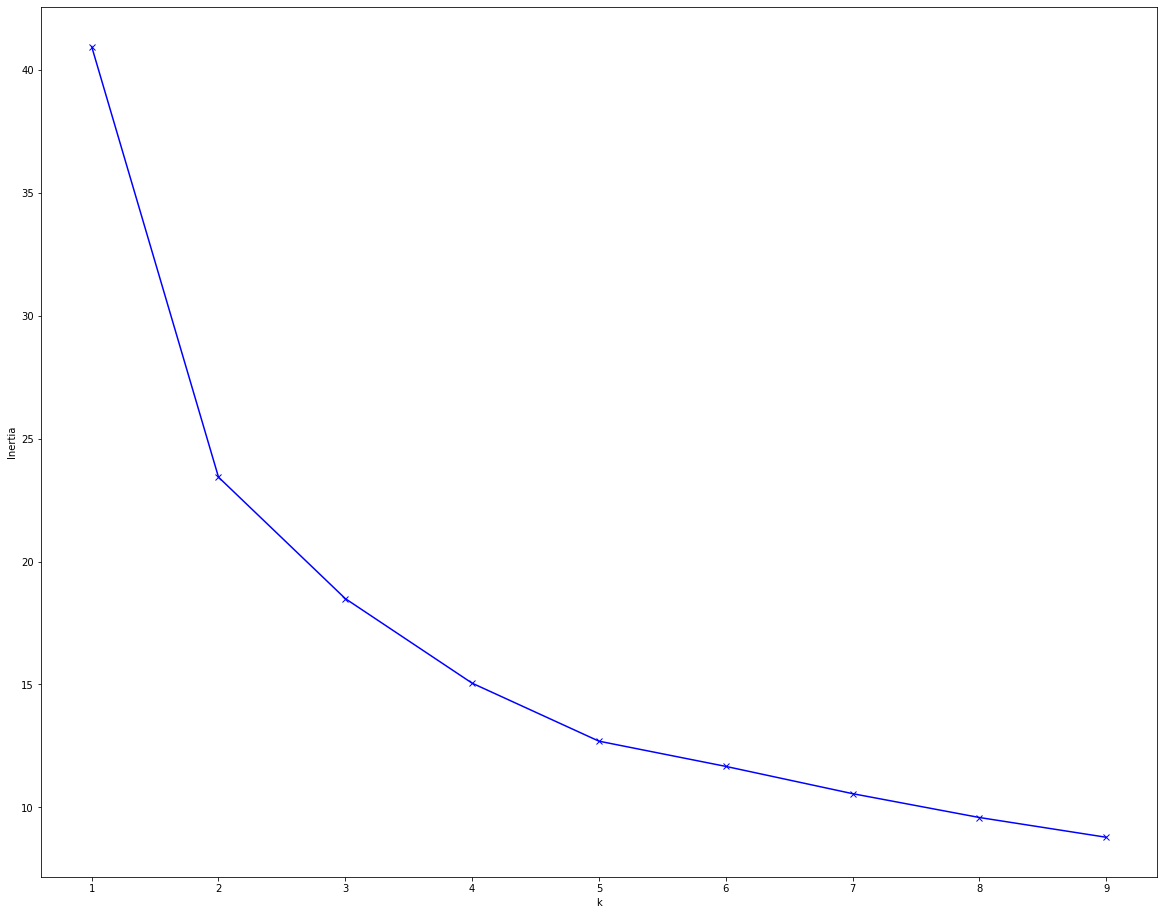

In [63]:
inertia = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(features_normal)
    kmeanModel.fit(features_normal)
    inertia.append(kmeanModel.inertia_)
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

In [64]:
kmeans = KMeans(n_clusters=5).fit(features_normal)

In [65]:
covidkmeans.head()

,TotalDeaths1M,TotalTests1M,GDPperCap,LifeExpect,DrsPer1k,NewInfecHIV,FertilityRate,UrbanPopulation
country,,,,,,,,
China,3.0,111163.0,9976.676822,76.704000,0.9186,1050.0,1.6900,823827650.0
United States,723.0,458433.0,62840.020239,78.539024,1.9357,33000.0,1.7295,268720071.0
India,90.0,81607.0,2005.863005,69.416000,0.8571,1050.0,2.2220,460295677.0
Brazil,756.0,102777.0,9001.234249,75.672000,2.1643,2300.0,1.7300,181335507.0
France,592.0,257477.0,41631.090739,82.724390,3.2672,500.0,1.8800,53870058.0


In [66]:
labels = pd.DataFrame(kmeans.labels_) #This is where the label output of the KMeans we just ran lives. Make it a dataframe so we can concatenate back to the original data
covidkmeans=covidkmeans.assign(Country=covidkmeans.index.get_level_values('country'))
covidkmeans.reset_index(drop=True, inplace=True)
labeledcovidkmeans = pd.concat((covidkmeans,labels), axis=1)
labeledcovidkmeans = labeledcovidkmeans.rename({0:'labels'},axis=1)

In [67]:
labeledcovidkmeans.head()

,TotalDeaths1M,TotalTests1M,GDPperCap,LifeExpect,DrsPer1k,NewInfecHIV,FertilityRate,UrbanPopulation,Country,labels
0,3.0,111163.0,9976.676822,76.704000,0.9186,1050.0,1.6900,823827650.0,China,3
1,723.0,458433.0,62840.020239,78.539024,1.9357,33000.0,1.7295,268720071.0,United States,2
2,90.0,81607.0,2005.863005,69.416000,0.8571,1050.0,2.2220,460295677.0,India,3
3,756.0,102777.0,9001.234249,75.672000,2.1643,2300.0,1.7300,181335507.0,Brazil,2
4,592.0,257477.0,41631.090739,82.724390,3.2672,500.0,1.8800,53870058.0,France,2


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


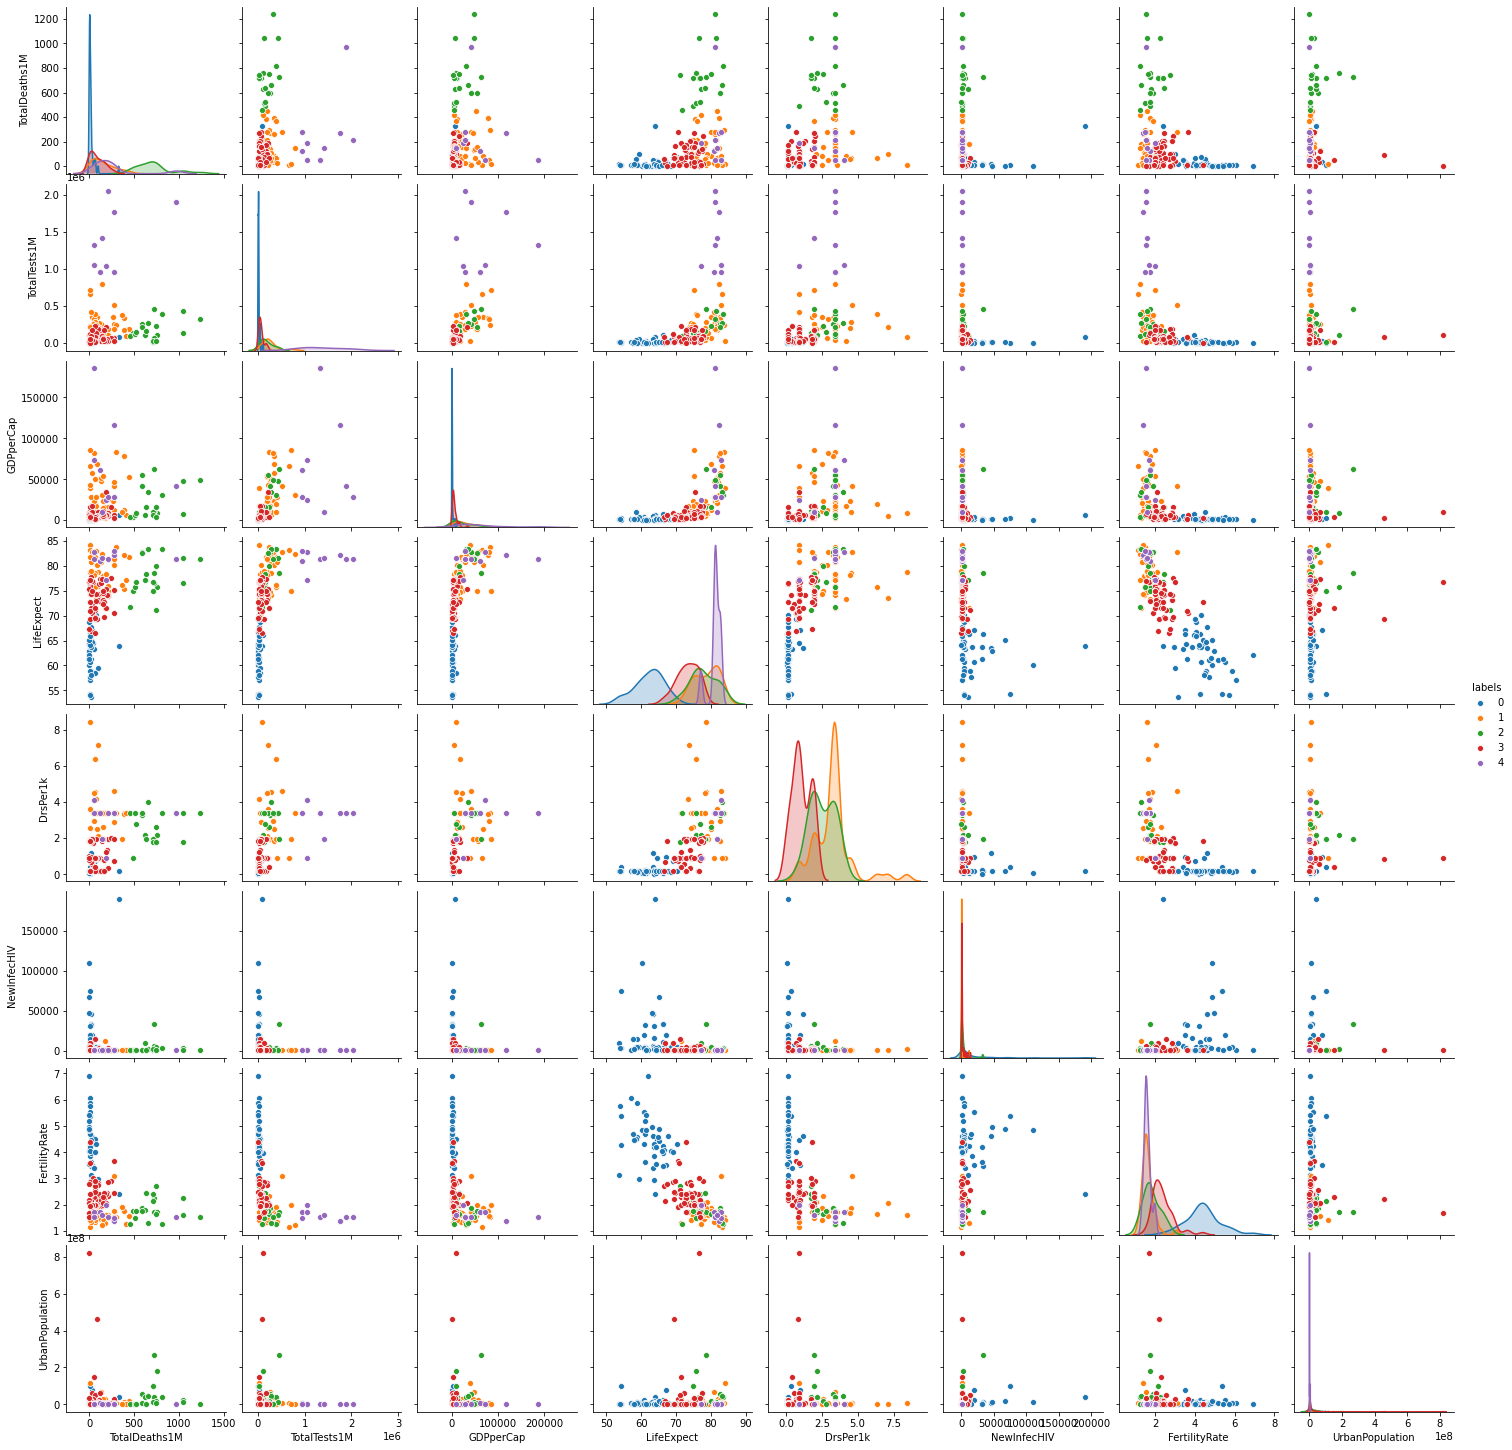

In [68]:
sns.pairplot(labeledcovidkmeans,hue='labels')

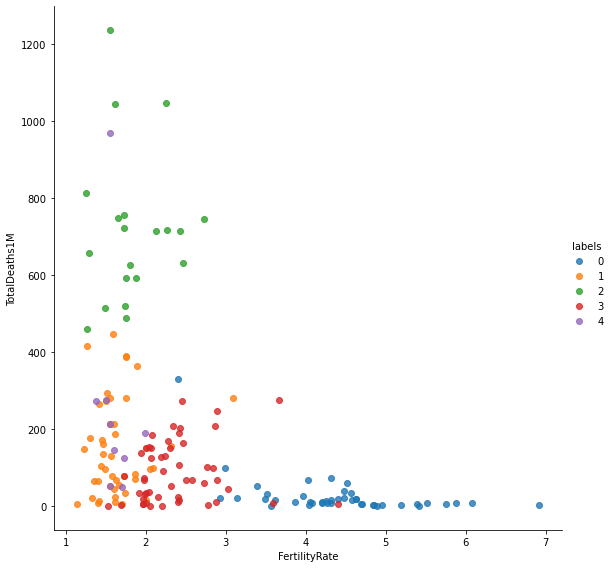

In [69]:
sns.lmplot(x='FertilityRate',y='TotalDeaths1M',data=labeledcovidkmeans,hue='labels',fit_reg=False, height=8)

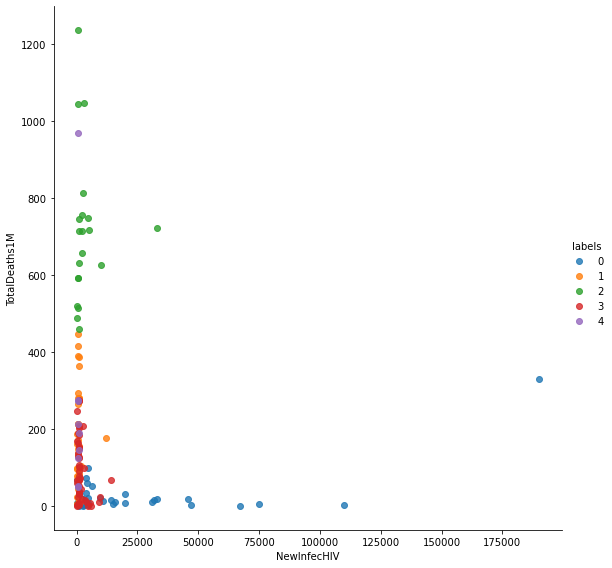

In [70]:
sns.lmplot(x='NewInfecHIV',y='TotalDeaths1M',data=labeledcovidkmeans,hue='labels',fit_reg=False,height=8)

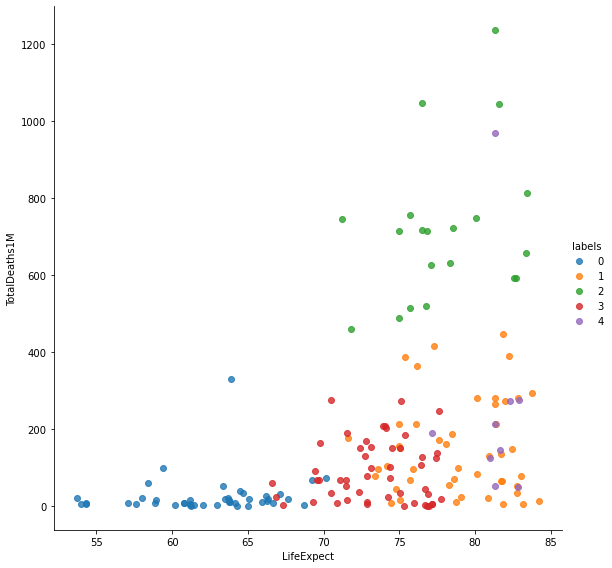

In [71]:
sns.lmplot(x='LifeExpect',y='TotalDeaths1M',data=labeledcovidkmeans,hue='labels',fit_reg=False, height=8)

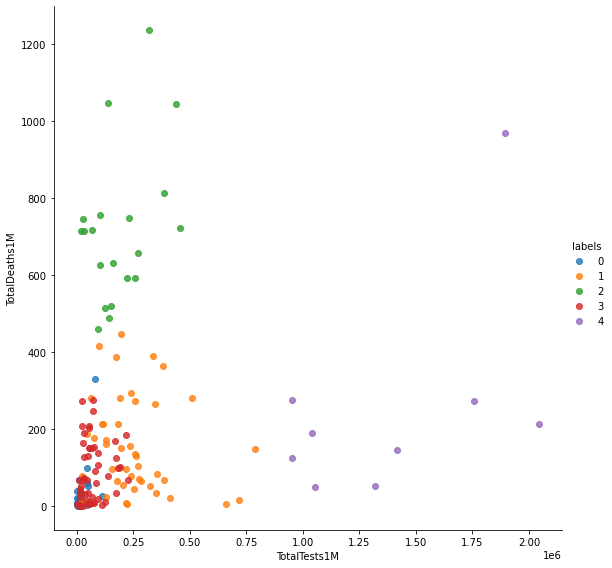

In [72]:
sns.lmplot(x='TotalTests1M',y='TotalDeaths1M',data=labeledcovidkmeans,hue='labels',fit_reg=False, height=8)

Finalmente, atendiendo a los clustering obtenidos por el modelo, se detecta que hay un grupo de países donde los parámetros parecen indicar que son países subdesarrollados, en los cuales se detectan un menor número de muertes debido a la pandemia de la COVID-19

| Contribuciones                         | Firma |
|----------------------------------------|-------|
| Investigación Inicial                  | <img src="../FirmaFran.jpg" alt="Firma Fran" style="float:left;" width="60"/><img src="../EnriqueOtero_Firma.jpg" alt="Firma Enrique" style="margin-left: 3px;float: right;" width="60"/>|
| Análisis de herramientas Scrappping    |<img src="../FirmaFran.jpg" alt="Firma Fran" style="float:left;" width="60"/><img src="../EnriqueOtero_Firma.jpg" alt="Firma Enrique" style="margin-left: 3px;float: right;" width="60"/>       |
| Codigo python Scrapping y app          |<img src="../FirmaFran.jpg" alt="Firma Fran" style="float:left;" width="60"/><img src="../EnriqueOtero_Firma.jpg" alt="Firma Enrique" style="margin-left: 3px;float: right;" width="60"/>       |
| Investigación de Indicadores WorldBank |<img src="../FirmaFran.jpg" alt="Firma Fran" style="float:left;" width="60"/><img src="../EnriqueOtero_Firma.jpg" alt="Firma Enrique" style="margin-left: 3px;float: right;" width="60"/>       |
| Obtención de datos Covid y WorldBank   |<img src="../FirmaFran.jpg" alt="Firma Fran" style="float:left;" width="60"/><img src="../EnriqueOtero_Firma.jpg" alt="Firma Enrique" style="margin-left: 3px;float: right;" width="60"/>       |
| Procesado y limpieza de Datos          |<img src="../FirmaFran.jpg" alt="Firma Fran" style="float:left;" width="60"/><img src="../EnriqueOtero_Firma.jpg" alt="Firma Enrique" style="margin-left: 3px;float: right;" width="60"/>       |
| Análisis ejemplo Clustering            |<img src="../FirmaFran.jpg" alt="Firma Fran" style="float:left;" width="60"/><img src="../EnriqueOtero_Firma.jpg" alt="Firma Enrique" style="margin-left: 3px;float: right;" width="60"/>       |
| Export de DataSet                      |<img src="../FirmaFran.jpg" alt="Firma Fran" style="float:left;" width="60"/><img src="../EnriqueOtero_Firma.jpg" alt="Firma Enrique" style="margin-left: 3px;float: right;" width="60"/>       |
| Documentacion                          |<img src="../FirmaFran.jpg" alt="Firma Fran" style="float:left;" width="60"/><img src="../EnriqueOtero_Firma.jpg" alt="Firma Enrique" style="margin-left: 3px;float: right;" width="60"/>       |